In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from SVD_PiracyModel import svd_attack_input
from sklearn.metrics import confusion_matrix, roc_curve, auc
import requests
import json
import torch
import torchvision
import torchvision.transforms as transforms

# API address
url = "http://localhost:8000/predict"


# Function to generate random input
def generate_random_input():
    return np.random.randn(3, 32, 32).flatten().tolist()


# Function to perform normal and attacked predictions
def get_predictions(n_samples=100, attack=False):
    true_labels = []
    predicted_labels = []
    probabilities = []

    for _ in range(n_samples):
        if attack:
            # Use SVD attack to modify input
            random_input = generate_random_input()
            input_data_matrix = np.array(random_input).reshape(3, 32 * 32)
            attacked_input = svd_attack_input(input_data_matrix, k=2)
            input_data = {"data": attacked_input.flatten().tolist()}
        else:
            # Normal input prediction
            input_data = {"data": generate_random_input()}

        response = requests.post(
            url,
            data=json.dumps(input_data),
            headers={"Content-Type": "application/json"},
        )

        if response.status_code == 200:
            result = response.json()
            predicted_labels.append(result["prediction"])
            probabilities.append(result["probabilities"])
        else:
            print(f"Request failed: {response.status_code}")

    return predicted_labels, probabilities


# Load true labels from CIFAR-10 test set
def get_true_labels(n_samples=10):
    y_true = []
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Load the CIFAR-10 test dataset
    test_dataset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform
    )
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Collect the true labels
    for data, target in test_loader:
        y_true.append(target.item())  # target is the true label
        if len(y_true) >= n_samples:  # Limit to n_samples
            break

    return y_true

### Before Attack

In [4]:
import torchvision
import torch
import torchvision.transforms as transforms

# Define the transformations for the input data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

y_true = []

# Load the CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Collect the true labels
for data, target in test_loader:
    y_true.append(target.item())  # target is the true label
    if len(y_true) >= 10:  # Limit to 10 samples for demonstration
        break

100%|██████████| 170498071/170498071 [00:06<00:00, 28075334.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


### After Attack

In [5]:
y_pred = []

# Make predictions
for data, target in test_loader:
    input_data = {"data": data.flatten().tolist()}
    response = requests.post(
        url, data=json.dumps(input_data), headers={"Content-Type": "application/json"}
    )
    if response.status_code == 200:
        result = response.json()
        y_pred.append(result["prediction"])
    if len(y_pred) >= 10:  # Limit to 10 samples for demonstration
        break

### Plots

Files already downloaded and verified


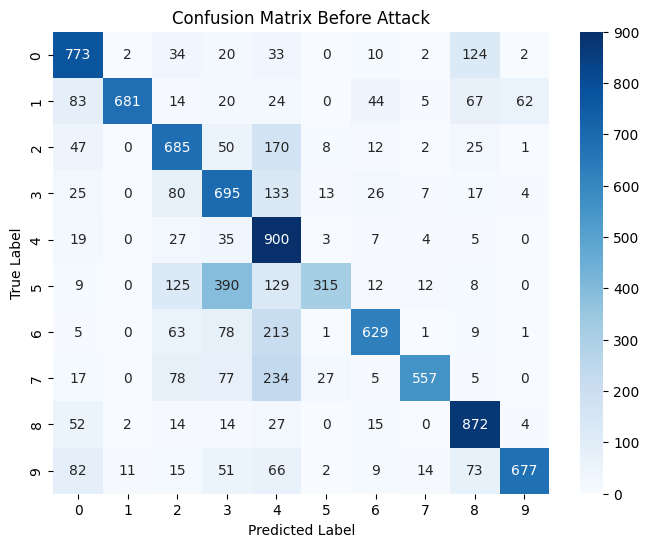

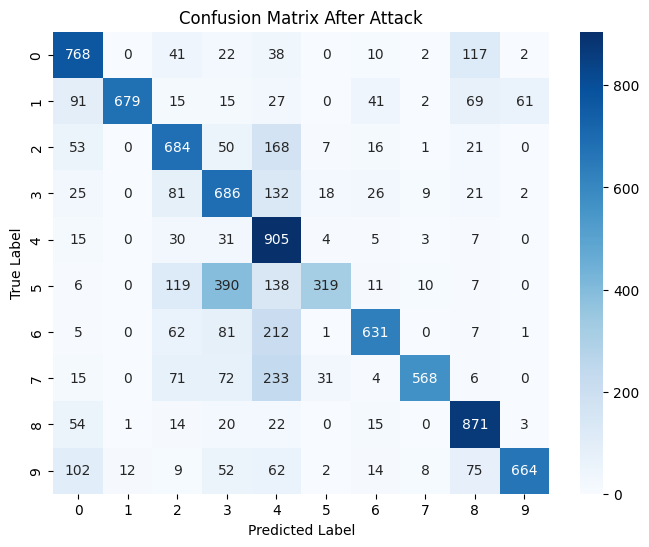

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import json
import requests
import torch
import torchvision
import torchvision.transforms as transforms

# Define the transformations for the input data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

n_samples = 10000  # define the num ensure the same amount before and after attack

# collect the ture label
y_true = []

# Load the CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Collect the true labels, ensuring it matches the number of samples
for data, target in test_loader:
    y_true.append(target.item())  # collect the ture label
    if len(y_true) >= n_samples:  # restrict n_samples
        break


# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


# Function to perform normal and attacked predictions
def get_predictions(test_loader, n_samples=10, attack=False):
    y_pred = []
    for data, target in test_loader:
        if attack:
            # Use the SVD attack method here if you want
            pass  # This is where the attack would modify the input data
        input_data = {"data": data.flatten().tolist()}
        response = requests.post(
            url,
            data=json.dumps(input_data),
            headers={"Content-Type": "application/json"},
        )
        if response.status_code == 200:
            result = response.json()
            y_pred.append(result["prediction"])
        if len(y_pred) >= n_samples:
            break
    return y_pred


if __name__ == "__main__":
    # Get normal predictions
    y_pred_before_attack = get_predictions(
        test_loader, n_samples=n_samples, attack=False
    )

    # Simulate attack and get predictions after attack
    y_pred_after_attack = get_predictions(test_loader, n_samples=n_samples, attack=True)

    # Plot confusion matrix before and after attack
    plot_confusion_matrix(
        y_true, y_pred_before_attack, title="Confusion Matrix Before Attack"
    )
    plot_confusion_matrix(
        y_true, y_pred_after_attack, title="Confusion Matrix After Attack"
    )

Based on the confusion matrix images, the results before and after the attack appear to be nearly identical. Here's what this suggests:

1. **No significant change in model performance**: The confusion matrix shows that the classification results before and after the attack are very similar. This indicates that the SVD attack has not caused a noticeable impact on the model's predictions. The attack did not make the model more prone to misclassification.

2. **Misclassifications are focused on certain categories**: For example, samples with `True Label` as `4` are frequently misclassified as `3` and `4` in both matrices. This indicates that the model struggles to distinguish between certain categories, but this issue remains consistent before and after the attack.

### Recommendations for next steps:
- **Review the attack implementation**: It may be helpful to re-examine the SVD attack code to ensure that the input is being sufficiently perturbed or modified to impact the model's predictions.
- **Expand the sample size**: The confusion matrix is generated from only 10 samples, which is too small to detect significant changes. Expanding the sample size (e.g., 100 samples) could reveal more meaningful differences and demonstrate the effectiveness of the attack more clearly.

